# Exchange Rate Prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping

### Utility

In [3]:
def plot_series(series):    
    plt.figure(figsize=(12,6))
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.grid(True)
    plt.plot(series)

### Download and preview data

In [4]:
end = datetime.now()
start = datetime(end.year-5,end.month,end.day)
currency = "CADCNY=X"
df = yf.download(currency, start,end)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,0
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,0
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,0
2019-05-20,5.0887,5.1517,5.0887,5.1362,5.1362,0
2019-05-21,5.0990,5.1537,5.0990,5.1427,5.1427,0


In [6]:
df.drop('Volume', axis=1, inplace=True)

In [7]:
df.shape

(1306, 5)

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000
mean,5.181561,5.199708,5.154555,5.183181,5.183181
std,0.116025,0.115139,0.116435,0.115715,0.115715
min,4.860398,4.915445,4.801252,4.872813,4.872813
25%,5.089037,5.106328,5.061461,5.090446,5.090446
50%,5.187896,5.208820,5.158957,5.189513,5.189513
75%,5.264461,5.281974,5.239087,5.266126,5.266126
max,5.496837,5.500776,5.443882,5.496722,5.496722


In [9]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Exchange Rate')

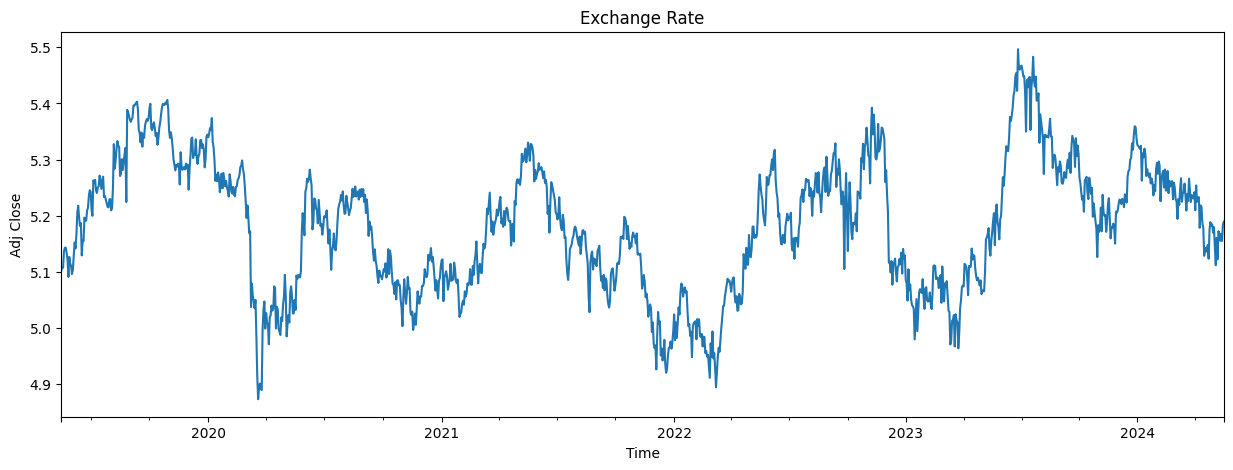

In [10]:
plt.figure(figsize = (15,5))
df['Adj Close'].plot()
plt.xlabel("Time")
plt.ylabel("Adj Close")
plt.title("Exchange Rate")

In [11]:
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize = figsize)
    plt.xlabel("Time")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Exchange Rate")

In [12]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

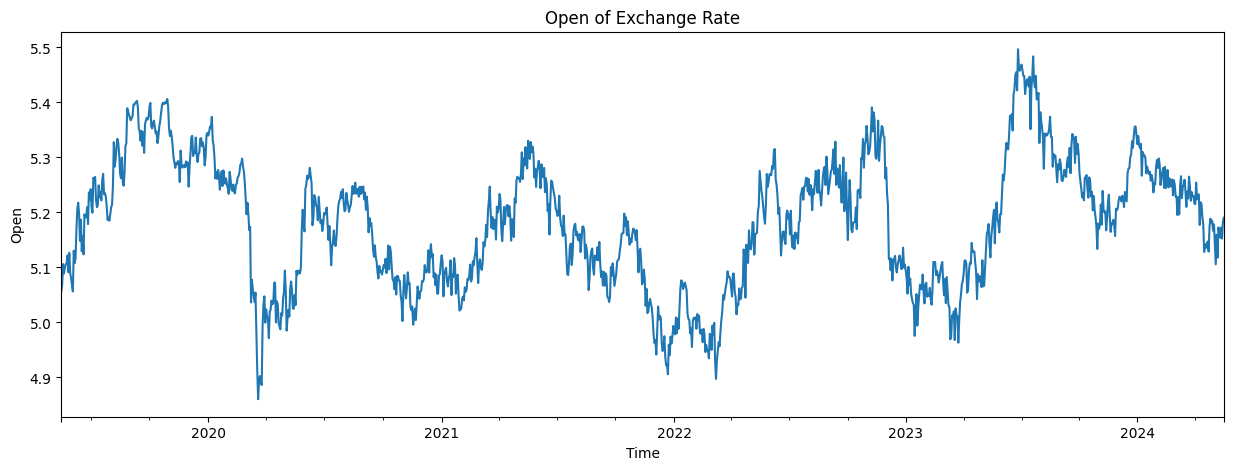

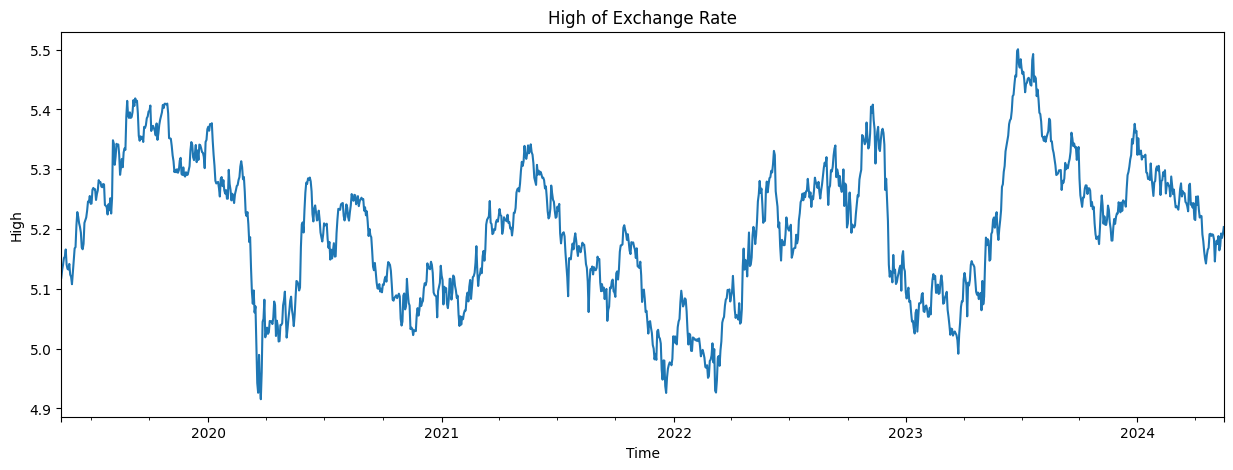

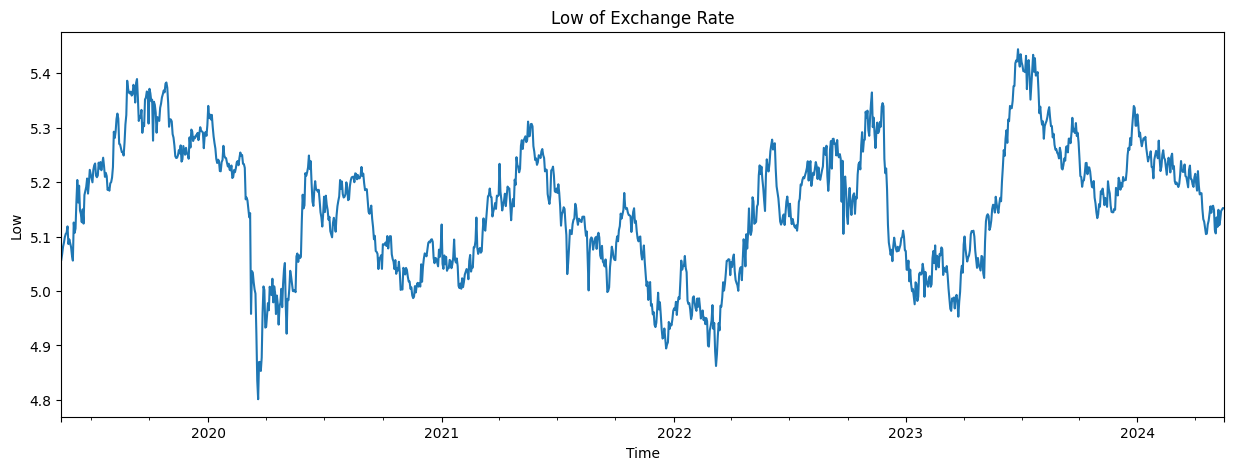

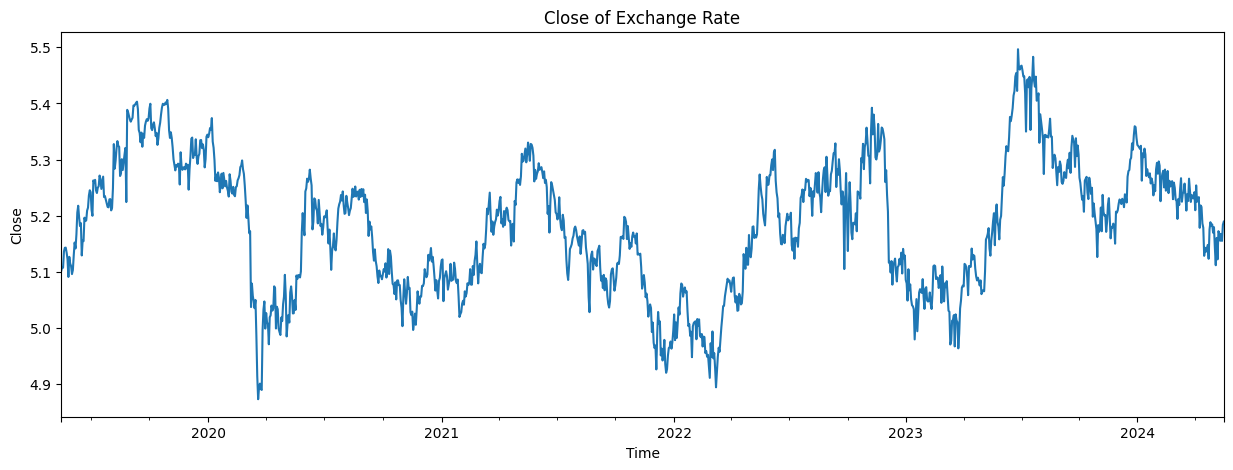

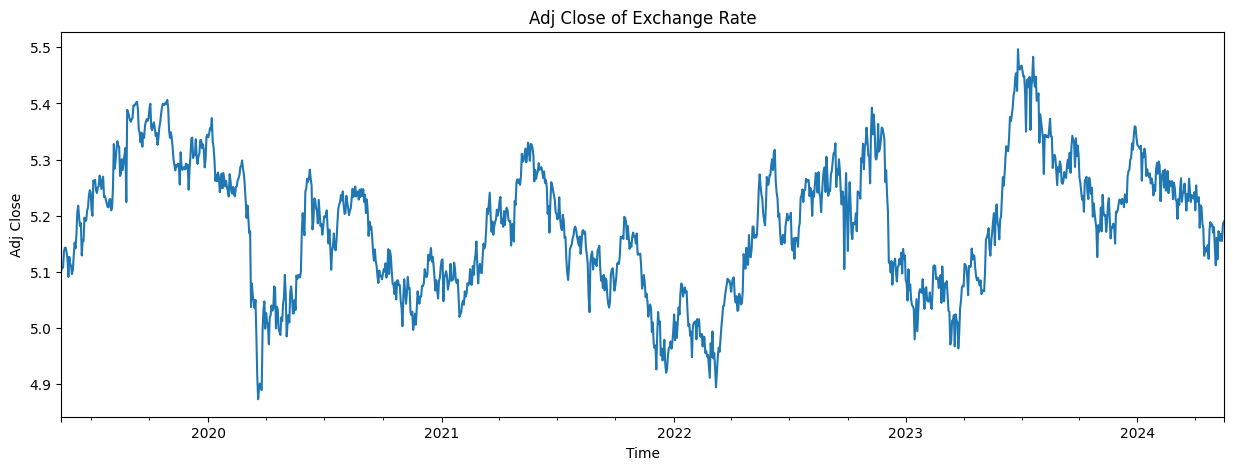

In [13]:
for column in df.columns:
    plot_graph((15,5),df[column], column)

<Figure size 640x480 with 0 Axes>

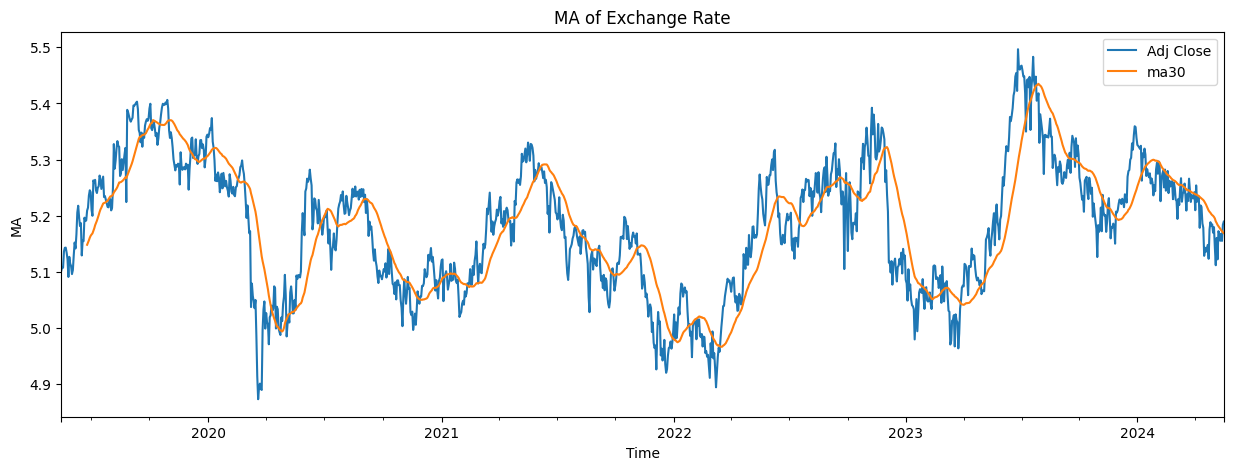

In [14]:
df['ma30']=df['Adj Close'].rolling(30).mean()
plot_graph((15,5), df[['Adj Close','ma30']], 'MA')

In [15]:
df['percentage_change_cp'] = df['Close'].pct_change()
df.head()

,Open,High,Low,Close,Adj Close,ma30,percentage_change_cp
Date,,,,,,,
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,NaN,NaN
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,NaN,0.001254
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,NaN,-0.000235
2019-05-20,5.0887,5.1517,5.0887,5.1362,5.1362,NaN,0.005678
2019-05-21,5.0990,5.1537,5.0990,5.1427,5.1427,NaN,0.001266


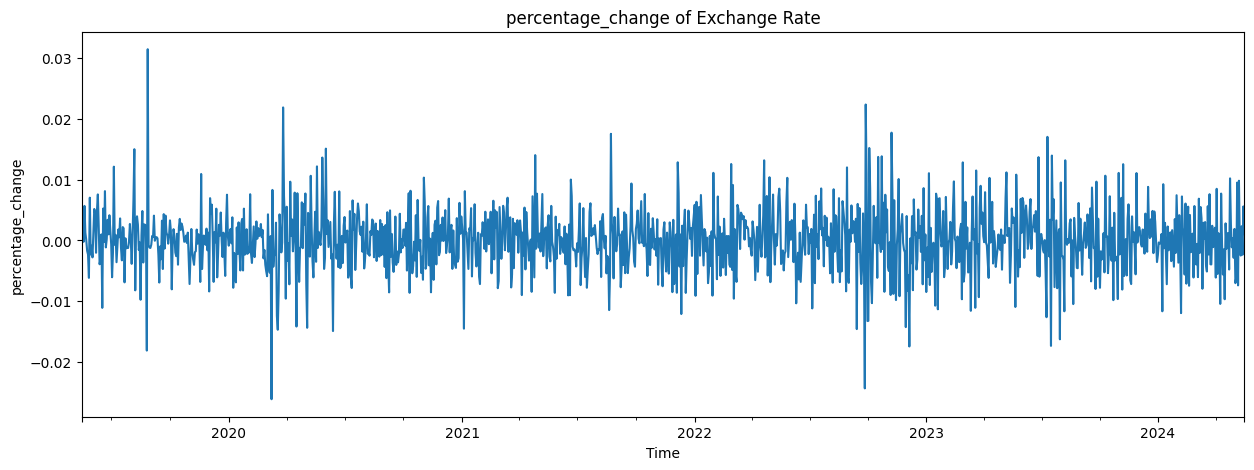

In [16]:
plot_graph((15,5), df['percentage_change_cp'], 'percentage_change')

In [17]:
Adj_close_price = df[['Adj Close']]

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)
scaled_data

array([[0.36734045],
       [0.37759777],
       [0.37567485],
       ...,
       [0.45235595],
       [0.49857234],
       [0.50735078]])

In [19]:
max(Adj_close_price.values),min(Adj_close_price.values) 

(array([5.49672222]), array([4.87281322]))

In [20]:
len(scaled_data)

1306

In [21]:
x_data = []
y_data = []
period = 10
for i in range(period, len(scaled_data)):
    x_data.append(scaled_data[i - period: i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

In [22]:
x_data[0],y_data[0]

(array([[0.36734045],
        [0.37759777],
        [0.37567485],
        [0.42215568],
        [0.43257426],
        [0.43321472],
        [0.41911081],
        [0.40003684],
        [0.34938843],
        [0.40676856]]),
 array([0.38769535]))

In [23]:
int(len(x_data)*0.7)

907

In [24]:
splitting_len = int(len(x_data)*0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(907, 10, 1)
(907, 1)
(389, 10, 1)
(389, 1)


### Model

In [26]:
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1], 1)))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 64))

model.add(Dense(units = 64))
model.add(Dense(units = 32))
model.add(Dense(units = 10))
model.add(Dense(units = 1))


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=1, epochs = 50, callbacks=[early_stopping])

Epoch 1/50

907/907 [==============================] - 9s 6ms/step - loss: 0.0097
Epoch 2/50
907/907 [==============================] - 5s 6ms/step - loss: 0.0055
Epoch 3/50
907/907 [==============================] - 5s 6ms/step - loss: 0.0046
Epoch 4/50
907/907 [==============================] - 5s 6ms/step - loss: 0.0041
Epoch 5/50
907/907 [==============================] - 21s 23ms/step - loss: 0.0037
Epoch 6/50
907/907 [==============================] - 30s 33ms/step - loss: 0.0037
Epoch 7/50
907/907 [==============================] - 11s 12ms/step - loss: 0.0032
Epoch 8/50
907/907 [==============================] - 5s 6ms/step - loss: 0.0033
Epoch 9/50
907/907 [==============================] - 6s 6ms/step - loss: 0.0033
Epoch 10/50
907/907 [==============================] - 22s 24ms/step - loss: 0.0036
Epoch 11/50
907/907 [==============================] - 21s 23ms/step - loss: 0.0030
Epoch 12/50
907/907 [==============================] - 21s 23ms/step - loss: 0.0029
Epoch 13/50


### Prediction

In [30]:
predictions = model.predict(x_test)

13/13 [==============================] - 3s 18ms/step


In [31]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[5.3194995],
       [5.345897 ],
       [5.3302207],
       [5.331222 ],
       [5.335323 ],
       [5.3481445],
       [5.351326 ],
       [5.3502345],
       [5.3449883],
       [5.3045893],
       [5.3001475],
       [5.2685943],
       [5.2391524],
       [5.1668878],
       [5.13632  ],
       [5.111594 ],
       [5.1208463],
       [5.0939264],
       [5.111169 ],
       [5.1196685],
       [5.127453 ],
       [5.111465 ],
       [5.0926876],
       [5.1061845],
       [5.112142 ],
       [5.123839 ],
       [5.1204357],
       [5.1348224],
       [5.112262 ],
       [5.137466 ],
       [5.1317215],
       [5.134196 ],
       [5.103479 ],
       [5.086646 ],
       [5.0585017],
       [5.094564 ],
       [5.0780377],
       [5.07947  ],
       [5.0606236],
       [5.044977 ],
       [5.038581 ],
       [5.033315 ],
       [4.9941406],
       [5.008786 ],
       [5.041738 ],
       [5.0116644],
       [5.0228286],
       [5.0539827],
       [5.0671573],
       [5.0668383],


In [32]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[5.36354685],
       [5.31426907],
       [5.31990385],
       [5.33405876],
       [5.35717106],
       [5.35495186],
       [5.34660387],
       [5.33607578],
       [5.25991297],
       [5.28100395],
       [5.23704576],
       [5.20727301],
       [5.11635208],
       [5.11796379],
       [5.09871817],
       [5.1190238 ],
       [5.07705212],
       [5.11134291],
       [5.11647606],
       [5.12344599],
       [5.09880686],
       [5.08272982],
       [5.10857916],
       [5.1109972 ],
       [5.12307787],
       [5.1133852 ],
       [5.134058  ],
       [5.09696007],
       [5.14080477],
       [5.1239872 ],
       [5.12895918],
       [5.08537292],
       [5.07932711],
       [5.04864979],
       [5.10448694],
       [5.06699419],
       [5.07745504],
       [5.05111504],
       [5.04046202],
       [5.03850317],
       [5.03347588],
       [4.97939491],
       [5.01769209],
       [5.05128288],
       [4.99399519],
       [5.02817822],
       [5.06307697],
       [5.069

In [33]:
rmse = np.sqrt(np.mean( (inv_predictions - inv_y_test)**2))

In [34]:
rmse

0.02891124297469786

In [35]:
ploting_data = pd.DataFrame(
 {
  'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
 } ,
    index = df.index[splitting_len+period:]
)
ploting_data.head()

,original_test_data,predictions
Date,,
2022-11-18,5.363547,5.319499
2022-11-21,5.314269,5.345897
2022-11-22,5.319904,5.330221
2022-11-23,5.334059,5.331222
2022-11-24,5.357171,5.335323


<Figure size 640x480 with 0 Axes>

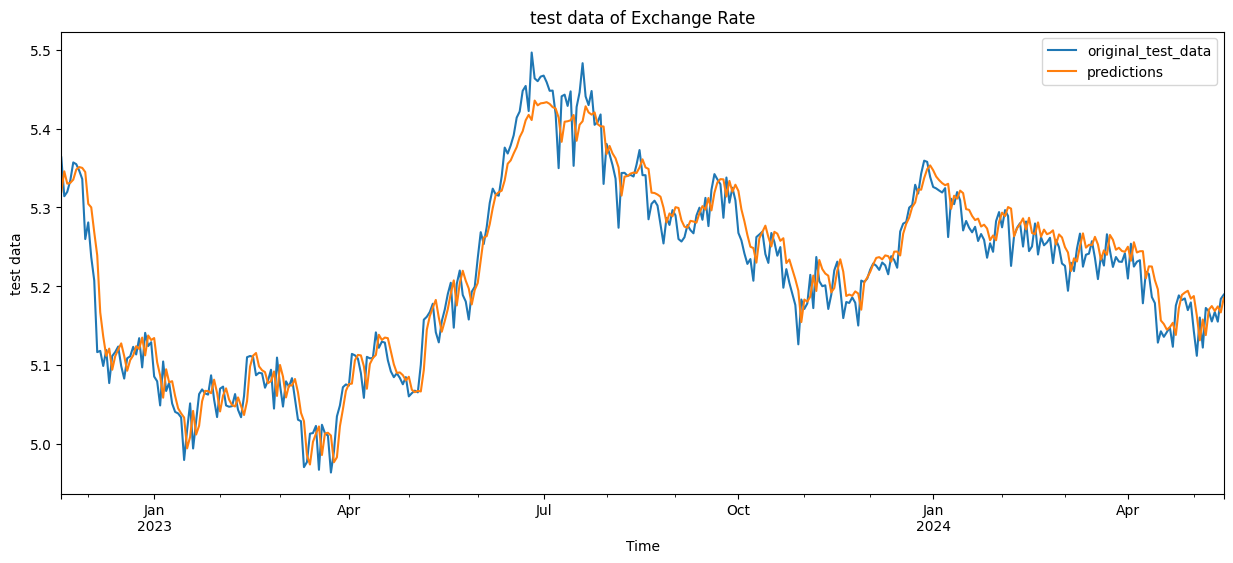

In [36]:
plot_graph((15,6), ploting_data, 'test data')

<Figure size 640x480 with 0 Axes>

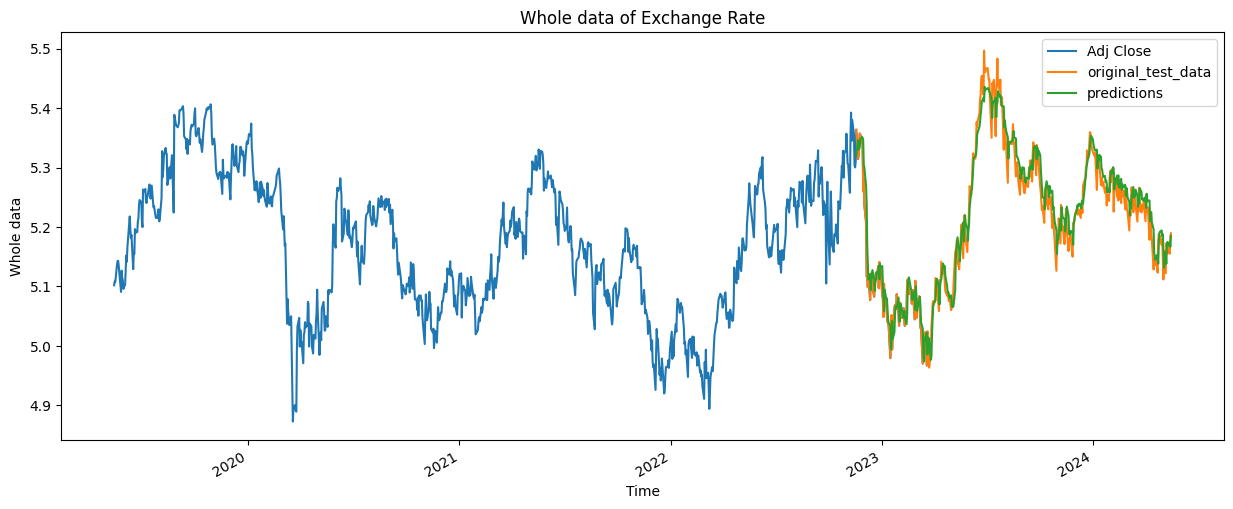

In [37]:
plot_graph((15,6), pd.concat([Adj_close_price[:splitting_len+100],ploting_data], axis=0), 'Whole data')

In [38]:
model.save("exchange_rate_predict_model.h5")

c:\Users\32482\PycharmProjects\ExchangeRateProphet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
